In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score,f1_score,r2_score,mean_squared_error, recall_score, precision_score
import matplotlib.pyplot as plt
from joblib import dump

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/기상청빅데이터/DATA/fog_train.csv')
test = pd.read_csv('/content/drive/MyDrive/기상청빅데이터/DATA/fog_test.csv')

In [ ]:
train

,Unnamed: 0,fog_train.year,fog_train.month,fog_train.day,fog_train.time,fog_train.minute,fog_train.stn_id,fog_train.ws10_deg,fog_train.ws10_ms,fog_train.ta,fog_train.re,fog_train.hm,fog_train.sun10,fog_train.ts,fog_train.vis1,fog_train.class
0,1,I,1,1,0,10,AA,0.0,0.0,-6.4,0.0,38.9,0.0,-2.8,20000,4
1,2,I,1,1,0,20,AA,0.0,0.0,-6.3,0.0,37.9,0.0,-2.7,20000,4
2,3,I,1,1,0,30,AA,0.0,0.0,-6.3,0.0,40.0,0.0,-2.6,20000,4
3,4,I,1,1,0,40,AA,27.8,0.4,-6.2,0.0,39.5,0.0,-2.6,20000,4
4,5,I,1,1,0,50,AA,59.7,0.5,-6.1,0.0,39.8,0.0,-2.5,20000,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3156454,3156455,K,12,31,23,10,EC,305.3,7.7,2.5,0.0,50.2,0.0,-0.9,20000,4
3156455,3156456,K,12,31,23,20,EC,293.8,5.7,2.3,0.0,50.1,0.0,-1.3,20000,4
3156456,3156457,K,12,31,23,30,EC,274.2,4.9,2.2,0.0,51.0,0.0,-1.4,20000,4
3156457,3156458,K,12,31,23,40,EC,270.3,4.6,2.1,0.0,51.7,0.0,-1.6,20000,4


In [ ]:
class_counts = train['fog_train.class'].value_counts()
class_counts

fog_train.class
 4     3101809
-99      22516
 3       12180
 2       12088
 1        7866
Name: count, dtype: int64

In [ ]:
from sklearn.metrics import confusion_matrix

def multiclass_csi(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    num_classes = cm.shape[0]
    H = np.zeros(num_classes)
    FM = np.zeros(num_classes)

    for i in range(num_classes):
        H[i] = cm[i, i]
        FM[i] = cm[i, :].sum() - H[i]

    H = H.sum() - cm[-1, -1]
    FM = FM.sum()
    csi = H / (H+FM)
    return csi

from sklearn.metrics import make_scorer

csi_scorer = make_scorer(multiclass_csi, greater_is_better=True)

## 0. datetime 객체 생성

파생변수 계산을 위해 필요함.

In [ ]:
# 윤년 포함 여부 확인 (2.29)

condition = (train['fog_train.month'] == 2) & (train['fog_train.day'] == 29)
filtered_df = train[condition]

filtered_df['fog_train.year'].describe() ## I 가 윤년 (2020년으로 가정 -> 어느 연도이든 상관없음)

count     2880
unique       1
top          I
freq      2880
Name: fog_train.year, dtype: object

In [ ]:
# datetime 생성을 위해 new_year 칼럼 생성

condition = [ (train['fog_train.year'] == 'I'), (train['fog_train.year'] == 'J'), (train['fog_train.year'] == 'K') ]
value = [ 2020, 2021, 2022 ]

train['new_year'] = np.select(condition, value)
train['new_year'].value_counts()

new_year
2020    1054060
2022    1051200
2021    1051199
Name: count, dtype: int64

In [ ]:
# 각 칼럼을 합쳐서 datetime으로 변환

train['datetime'] = train['new_year'].map(str) + "-" + train['fog_train.month'].astype(str).str.zfill(2) + "-" + train['fog_train.day'].astype(str).str.zfill(2) + " " + train['fog_train.time'].astype(str).str.zfill(2) + ":" + train['fog_train.minute'].map(str)
train['datetime'] = pd.to_datetime(train.datetime)
train['datetime']

0         2020-01-01 00:10:00
1         2020-01-01 00:20:00
2         2020-01-01 00:30:00
3         2020-01-01 00:40:00
4         2020-01-01 00:50:00
                  ...        
3156454   2022-12-31 23:10:00
3156455   2022-12-31 23:20:00
3156456   2022-12-31 23:30:00
3156457   2022-12-31 23:40:00
3156458   2022-12-31 23:50:00
Name: datetime, Length: 3156459, dtype: datetime64[ns]

In [ ]:
# 일별 강수강도, 당일 최고 최저기온, 일사량 계산시 사용

train['date'] = train['datetime'].dt.date

## 1-1. train dataset 기본변수 결측치 처리

In [ ]:
# 결측치 np.nan으로 변경

train = train.replace(-99.9, np.nan)
train = train.replace(-99, np.nan)

In [ ]:
# 칼럼별 결측치 개수

train.isnull().sum()

Unnamed: 0                0
fog_train.year            0
fog_train.month           0
fog_train.day             0
fog_train.time            0
fog_train.minute          0
fog_train.stn_id          0
fog_train.ws10_deg     5910
fog_train.ws10_ms      5826
fog_train.ta           3867
fog_train.re          15228
fog_train.hm           3616
fog_train.sun10       43910
fog_train.ts          88639
fog_train.vis1        22516
fog_train.class       22516
new_year                  0
datetime                  0
date                      0
dtype: int64

In [ ]:
# dataframe의 칼럼명을 담은 인덱스 리스트생성

train_var = train.columns
train_var = train_var[1:]
print(train_var)


# 이산변수만 담은 리스트
train_var_dis = [train_var[i] for i in [0, 1, 2, 3, 4, 5, 9, 14]]
print(train_var_dis)

# 연속변수만 리은 리스트
train_var_con = [item for item in train_var if item not in train_var_dis]
print(train_var_con)

Index(['fog_train.year', 'fog_train.month', 'fog_train.day', 'fog_train.time',
       'fog_train.minute', 'fog_train.stn_id', 'fog_train.ws10_deg',
       'fog_train.ws10_ms', 'fog_train.ta', 'fog_train.re', 'fog_train.hm',
       'fog_train.sun10', 'fog_train.ts', 'fog_train.vis1', 'fog_train.class',
       'new_year', 'datetime', 'date'],
      dtype='object')
['fog_train.year', 'fog_train.month', 'fog_train.day', 'fog_train.time', 'fog_train.minute', 'fog_train.stn_id', 'fog_train.re', 'fog_train.class']
['fog_train.ws10_deg', 'fog_train.ws10_ms', 'fog_train.ta', 'fog_train.hm', 'fog_train.sun10', 'fog_train.ts', 'fog_train.vis1', 'new_year', 'datetime', 'date']


In [ ]:
# 기상변수는 무작위 결측 (관측기기간 상관관계 없음)

# 연속변수
## 이전 행 값 사용
for var in train_var_con :
  train[str(var)] = train[str(var)].interpolate(method='pad')

# 이산변수
## 이전 행 값 사용
for var in train_var_dis :
  train[str(var)] = train[str(var)].interpolate(method='pad')


In [ ]:
# 결측치 처리완료

train.isnull().sum() # 0으로 뜸 다.


Unnamed: 0            0
fog_train.year        0
fog_train.month       0
fog_train.day         0
fog_train.time        0
fog_train.minute      0
fog_train.stn_id      0
fog_train.ws10_deg    0
fog_train.ws10_ms     0
fog_train.ta          0
fog_train.re          0
fog_train.hm          0
fog_train.sun10       0
fog_train.ts          0
fog_train.vis1        0
fog_train.class       0
new_year              0
datetime              0
date                  0
dtype: int64

In [ ]:
# train dataframe 보관.

train1 = train.copy()

## 1-2. test dataset 결측치 처리 (class 제외)



In [ ]:
# 결측치 np.nan으로 변경

test = test.replace(-99.9, np.nan)
test = test.replace(-99, np.nan)

In [ ]:
test.isnull().sum()

Unnamed: 0                0
fog_test.year             0
fog_test.month            0
fog_test.day              0
fog_test.time             0
fog_test.minute           0
fog_test.stn_id           0
fog_test.ws10_deg       224
fog_test.ws10_ms        224
fog_test.ta              91
fog_test.re            4503
fog_test.hm              57
fog_test.sun10          115
fog_test.ts            7643
fog_test.class       262800
dtype: int64

In [ ]:
# dataframe의 칼럼명을 담은 인덱스 리스트생성

test_var = test.columns
test_var = test_var[1:]
print(test_var)

# 이산변수만 담은 리스트
test_var_dis = [test_var[i] for i in [0, 1, 2, 3, 4, 5, 9, 13]]


# 연속변수만 리은 리스트
test_var_con = [item for item in test_var if item not in test_var_dis]
print(test_var_con)

test_var_dis.pop() # class 제외!
print(test_var_dis)

Index(['fog_test.year', 'fog_test.month', 'fog_test.day', 'fog_test.time',
       'fog_test.minute', 'fog_test.stn_id', 'fog_test.ws10_deg',
       'fog_test.ws10_ms', 'fog_test.ta', 'fog_test.re', 'fog_test.hm',
       'fog_test.sun10', 'fog_test.ts', 'fog_test.class'],
      dtype='object')
['fog_test.ws10_deg', 'fog_test.ws10_ms', 'fog_test.ta', 'fog_test.hm', 'fog_test.sun10', 'fog_test.ts']
['fog_test.year', 'fog_test.month', 'fog_test.day', 'fog_test.time', 'fog_test.minute', 'fog_test.stn_id', 'fog_test.re']


In [ ]:
# 기상변수는 무작위 결측 (관측기기간 상관관계 없음)

# 연속변수
## linear 하게 interpolate
for var in test_var_con :
  test[str(var)] = test[str(var)].interpolate(method='linear')

# 이산변수
## 이전 행 값 사용
for var in test_var_dis :
  test[str(var)] = test[str(var)].interpolate(method='pad')


In [ ]:
test.isnull().sum() # class 제외 결측치 처리 완.

Unnamed: 0                0
fog_test.year             0
fog_test.month            0
fog_test.day              0
fog_test.time             0
fog_test.minute           0
fog_test.stn_id           0
fog_test.ws10_deg         0
fog_test.ws10_ms          0
fog_test.ta               0
fog_test.re               0
fog_test.hm               0
fog_test.sun10            0
fog_test.ts               0
fog_test.class       262800
dtype: int64

## 2. 파생변수 생성 및 변수 가공


In [ ]:
# 칼럼부터 정리해보겠음.

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3156459 entries, 0 to 3156458
Data columns (total 19 columns):
 #   Column              Dtype         
---  ------              -----         
 0   Unnamed: 0          int64         
 1   fog_train.year      object        
 2   fog_train.month     int64         
 3   fog_train.day       int64         
 4   fog_train.time      int64         
 5   fog_train.minute    int64         
 6   fog_train.stn_id    object        
 7   fog_train.ws10_deg  float64       
 8   fog_train.ws10_ms   float64       
 9   fog_train.ta        float64       
 10  fog_train.re        float64       
 11  fog_train.hm        float64       
 12  fog_train.sun10     float64       
 13  fog_train.ts        float64       
 14  fog_train.vis1      float64       
 15  fog_train.class     float64       
 16  new_year            int64         
 17  datetime            datetime64[ns]
 18  date                object        
dtypes: datetime64[ns](1), float64(9), int64(6)

In [ ]:
# 필요없는 거 삭제

train = train.drop(columns = ['Unnamed: 0', 'fog_train.year', 'fog_train.day', 'new_year'])

### 1) 풍향

In [ ]:
# 풍향 Fourier feature

import math

train['fog_train.ws10_deg_cos'] = train['fog_train.ws10_deg'].apply(lambda x : math.cos(x)) # x-axis
train['fog_train.ws10_deg_sin'] = train['fog_train.ws10_deg'].apply(lambda x : math.sin(x)) # y-axis

### 2) 시각 (시간+분)

In [ ]:
# 시간 + 분을 시간 한개로 합치기

train['fog_train.minute'] = train['fog_train.minute'] / 60
train['time'] = train['fog_train.time'] + train['fog_train.minute']

In [ ]:
# 시간 Fourier feature

train['time_sin'] = train['time'].apply(lambda x: np.sin(2 * np.pi * x / 24))
train['time_cos'] = train['time'].apply(lambda x: np.cos(2 * np.pi * x / 24))

### 3) 계절 (month 처리)

In [ ]:
# month 처리
## 겨울(0), 봄(1), 여름(2), 가을(3) 계절별로 나눔

conditions = [
    (train['fog_train.month'] == 12) | (train['fog_train.month'] <= 2), # 겨울
    (train['fog_train.month'] >= 3) & (train['fog_train.month'] <= 5), # 봄
    (train['fog_train.month'] >= 6) & (train['fog_train.month'] <= 8), # 여름
    (train['fog_train.month'] >= 9) & (train['fog_train.month'] <= 11) # 가을
    ]

values = [0, 1, 2, 3]

train['season'] = np.select(conditions, values)

train['season'].value_counts()

season
1    794880
2    794880
3    786239
0    780460
Name: count, dtype: int64

In [ ]:
# 칼럼 정리2
## 필요없는 칼럼 버리기

train = train.drop(columns = ['fog_train.month', 'fog_train.time', 'fog_train.minute', 'time', 'fog_train.ws10_deg'])
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3156459 entries, 0 to 3156458
Data columns (total 16 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   fog_train.stn_id        object        
 1   fog_train.ws10_ms       float64       
 2   fog_train.ta            float64       
 3   fog_train.re            float64       
 4   fog_train.hm            float64       
 5   fog_train.sun10         float64       
 6   fog_train.ts            float64       
 7   fog_train.vis1          float64       
 8   fog_train.class         float64       
 9   datetime                datetime64[ns]
 10  date                    object        
 11  fog_train.ws10_deg_cos  float64       
 12  fog_train.ws10_deg_sin  float64       
 13  time_sin                float64       
 14  time_cos                float64       
 15  season                  int64         
dtypes: datetime64[ns](1), float64(12), int64(1), object(2)
memory usage: 385.3+ MB
None


### 4) 파생변수들


1. 대기-지면 온도차 : 'Tdiff'

2. 5시간 기온변화량 : 'ta5'
3. 하루 일사량 : 'daily_rad'

4. 이슬점온도 : 'td'
5. 포차 : 'td_dep'

6. qv 벡터 크기 -> X (기압정보없어 못구함)
7. 전 날 강수 : 're_pow_pre'

8. 하루 중 최저기온 : 'ta_max'
9. 하루 중 최고기온 : 'ta_min'
10. 일교차 : 'ta_range'

11. 포화혼합비, 포화수증기압, 지표면 포화수증기압 -> 의미없음. 기온과 같음. 기각

#### (1) 대기-지면 온도차

ta - ts

In [ ]:
#1. 대기-지면 온도차

train['Tdiff'] = train['fog_train.ta'] - train['fog_train.ts']
train['Tdiff']

0         -3.6
1         -3.6
2         -3.7
3         -3.6
4         -3.6
          ... 
3156454    3.4
3156455    3.6
3156456    3.6
3156457    3.7
3156458    3.8
Name: Tdiff, Length: 3156459, dtype: float64

#### 2) 5시간 기온변화량

ta - ta(5 hours ago)

In [ ]:
#2. 5시간 기온변화량

# 관측소 별로 묶어서 계산
train['ta5'] = train.groupby('fog_train.stn_id')['fog_train.ta'].diff(periods=30)
train['ta5'] # 첫 6x5=30 행은 NaN 값 발생

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
          ... 
3156454   -1.5
3156455   -1.5
3156456   -1.6
3156457   -1.5
3156458   -1.4
Name: ta5, Length: 3156459, dtype: float64

In [ ]:
# 젤 처음으로 나오는 유효값과 일치시킨다.

# 인덱스
first_valid_index = train['ta5'].first_valid_index()

# 값
first_valid_value = train.loc[first_valid_index, 'ta5']

# 채우기
train['ta5'].fillna(first_valid_value, inplace=True)

train['ta5'] # 해결완료

0          1.3
1          1.3
2          1.3
3          1.3
4          1.3
          ... 
3156454   -1.5
3156455   -1.5
3156456   -1.6
3156457   -1.5
3156458   -1.4
Name: ta5, Length: 3156459, dtype: float64

#### 3) 일사량

당일 일사량 합계

In [ ]:
#3. 일사량

train['daily_rad'] = train.groupby(['fog_train.stn_id', 'date'])['fog_train.sun10'].transform('sum')

In [ ]:
train['daily_rad']

0           4.53
1           4.53
2           4.53
3           4.53
4           4.53
           ...  
3156454    12.14
3156455    12.14
3156456    12.14
3156457    12.14
3156458    12.14
Name: daily_rad, Length: 3156459, dtype: float64

#### 4) 이슬점온도

td

In [ ]:
#4. 이슬점온도

## Magnus 수식 쓸건데 log(상대습도/100) -> log 0 나오면 계산안됨
train['fog_train.hm'].min() # 상대습도 0인 데이터가 있음..

0.0

In [ ]:
## Magnus-Tetens formula

b = 17.62
c = 243.12

gamma = (b * train['fog_train.ta'] /(c + train['fog_train.ta'])) + np.log(train['fog_train.hm'] / 100.0 + 1e-10) # 아주 작은 수를 더해준다. (결과 큰 영향없음)
train['td'] = (c * gamma) / (b - gamma)
train['td']

0         -18.138384
1         -18.355608
2         -17.717820
3         -17.776439
4         -17.596177
             ...    
3156454    -6.836571
3156455    -7.047605
3156456    -6.908457
3156457    -6.823619
3156458    -6.425684
Name: td, Length: 3156459, dtype: float64

#### 5) 포차

ta - td

In [ ]:
#5. 포차 (dew point depression)
## 포차 = 기온 - 이슬점 (상대습도 개념과 유사, 얼마나 포화되어있는가)

train['td_dep'] = train['fog_train.ta'] - train['td']
train['td_dep']

0          11.738384
1          12.055608
2          11.417820
3          11.576439
4          11.496177
             ...    
3156454     9.336571
3156455     9.347605
3156456     9.108457
3156457     8.923619
3156458     8.525684
Name: td_dep, Length: 3156459, dtype: float64

#### 7) 전날 강수강도

전날의 강수강도 (강수유무의 평균)을 당일 행들에 나타낸 것

In [ ]:
#7. 전날 강수강도

## 일별 강수강도 = 24시간 강수유무(0,1)의 평균

# 각 관측소 + 일자 별로 일별 강수강도 계산하여 저장
daily_rain_power = train.groupby(['fog_train.stn_id', 'date'])['fog_train.re'].mean()

# 전날 강수강도를 'rain_pre_power' 열에 할당
train['re_pow_pre'] = train.apply(lambda row: daily_rain_power.get((row['fog_train.stn_id'], row['datetime'].date() - pd.Timedelta(days=1)), 0), axis=1)
## NaN 값이 발생할걸로 예상되는 첫날도 0으로 채워줌.
## train.apply 써서 좀 느릴 수 있음. (2분 소요)

KeyboardInterrupt: 

In [ ]:
print(daily_rain_power.describe())
train['re_pow_pre']

#### 8) 당일 최고기온

당일의 최고기온을 해당일의 모든 행에 추가

In [ ]:
#8. 당일 최고기온

# 관측소(stn_id)별로 각 날짜의 최고기온을 구하여 'ta_max' 칼럼에 추가
train['ta_max'] = train.groupby(['fog_train.stn_id', 'date'])['fog_train.ta'].transform('max')

In [ ]:
train['ta_max']

#### 9) 당일 최저기온

당일의 최저기온을 해당일의 모든 행에 추가

In [ ]:
#8. 당일 최저기온

# 관측소(stn_id)별로 각 날짜의 최저기온을 구하여 'ta_min' 칼럼에 추가
train['ta_min'] = train.groupby(['fog_train.stn_id', 'date'])['fog_train.ta'].transform('min')

In [ ]:
train['ta_min']

#### 10) 일교차

당일 최고 - 최저기온



In [ ]:
train['ta_range'] = train['ta_max'] - train['ta_min']
train['ta_range']

In [ ]:
## 잘 구성되어있는지 확인

train.describe()

## 3. 정규화

In [ ]:
# vis1, class 칼럼 맨 뒤로 이동 (왜?) - > 보기 편해서

columns = [col for col in train.columns if col != 'fog_train.vis1'] + ['fog_train.vis1']
train = train[columns]

columns = [col for col in train.columns if col != 'fog_train.class'] + ['fog_train.class']
train = train[columns]
train

In [ ]:
# 칼럼 확인

train.info()

In [ ]:
# NaN 값 확인

train.isnull().sum()

In [ ]:
# 정규화

from sklearn.preprocessing import StandardScaler
from joblib import dump

columns_to_scale = ['fog_train.ws10_ms', 'fog_train.ta', 'fog_train.re', 'fog_train.hm', 'fog_train.sun10', 'fog_train.ts',
                    'fog_train.ws10_deg_cos', 'fog_train.ws10_deg_sin', 'time_sin', 'time_cos',
                    'season', 'Tdiff', 'ta5', 'td', 'td_dep',
                    're_pow_pre', 'ta_max', 'ta_min', 'ta_range', 'daily_rad']

sd_scaler = StandardScaler()

sd_scaler.fit(train[columns_to_scale])
train[columns_to_scale] = sd_scaler.transform(train[columns_to_scale])

dump(sd_scaler, 'sd_scaler.bin', compress = True)

train

## 4. Train A~E 데이터 추출 (까지 완)

In [ ]:
# A~E train 데이터 추출

## PCA 돌릴준비

# float 아닌거 삭제
train = train.drop(columns = ['datetime', 'date'])

#-------------------------------------------------------------------------------------------------------------------# 여기까지 test 데이터로 만들어야돼

train_A = train[train['fog_train.stn_id'].str.startswith('A')]
train_B = train[train['fog_train.stn_id'].str.startswith('B')]
train_C = train[train['fog_train.stn_id'].str.startswith('C')]
train_D = train[train['fog_train.stn_id'].str.startswith('D')]
train_E = train[train['fog_train.stn_id'].str.startswith('E')]

# 이제 쓸모가 없는 관측소 데이터 삭제
train_A = train_A.drop(columns = ['fog_train.stn_id'])
train_B = train_B.drop(columns = ['fog_train.stn_id'])
train_C = train_C.drop(columns = ['fog_train.stn_id'])
train_D = train_D.drop(columns = ['fog_train.stn_id'])
train_E = train_E.drop(columns = ['fog_train.stn_id'])

train_A.to_csv('train_A.csv', index=False)
train_B.to_csv('train_B.csv', index=False)
train_C.to_csv('train_C.csv', index=False)
train_D.to_csv('train_D.csv', index=False)
train_E.to_csv('train_E.csv', index=False)

In [ ]:
plt.figure(figsize=(16,16))
cmap = sns.light_palette(color = "b", as_cmap = True)
sns.heatmap(train_A.corr(), annot = True, cmap = cmap)
plt.show()

In [ ]:
train_A

## 5. 주성분 분석

In [ ]:
train_A = pd.read_csv('/content/drive/MyDrive/기상청빅데이터/과제 2/모델 중간 데이터/train_A.csv')

In [ ]:
!pip install factor_analyzer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 1.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for factor_analyzer: filename=factor_analyzer-0.5.1-py2.py3-none-any.whl size=42565 sha256=36268bd2b8519125606a86192b597ef32fbdd41fce7fbe5e4987bb1861ee06cf
  Stored in directory: /root/.cache/pip/wheels/24/59/82/6493618e30ed1cb7a013b9e1b0c9e17de80b04dfcef4ba8a4d
Successfully built factor_analyzer


In [ ]:
# feature 확인하시오
train_A.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1262584 entries, 0 to 1262583
Data columns (total 22 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   fog_train.ws10_ms       1262584 non-null  float64
 1   fog_train.ta            1262584 non-null  float64
 2   fog_train.re            1262584 non-null  float64
 3   fog_train.hm            1262584 non-null  float64
 4   fog_train.sun10         1262584 non-null  float64
 5   fog_train.ts            1262584 non-null  float64
 6   fog_train.ws10_deg_cos  1262584 non-null  float64
 7   fog_train.ws10_deg_sin  1262584 non-null  float64
 8   time_sin                1262584 non-null  float64
 9   time_cos                1262584 non-null  float64
 10  season                  1262584 non-null  float64
 11  Tdiff                   1262584 non-null  float64
 12  ta5                     1262584 non-null  float64
 13  daily_rad               1262584 non-null  float64
 14  td

In [ ]:
from sklearn.decomposition import PCA

# 필요한 패키지/모듈 가져오기
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
%matplotlib inline

from factor_analyzer import FactorAnalyzer

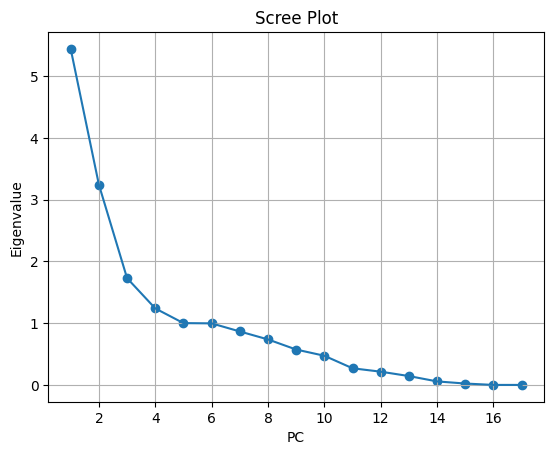

In [ ]:
PCA_df_train_A = train_A.drop(columns = ['fog_train.re', 'fog_train.hm', 'td_dep', 'fog_train.vis1', 'fog_train.class']) # 상대습도는 왜...? -> 여기서 드랍한거 제외하고 pca돌려서 변수 개수 줄임

# 기울기 확 완만해지는데 = pca 개수
fa = FactorAnalyzer(n_factors=PCA_df_train_A.shape[1], rotation=None)
fa.fit(PCA_df_train_A)
ev, v = fa.get_eigenvalues()
plt.scatter(range(1, PCA_df_train_A.shape[1]+1),ev)
plt.plot(range(1,PCA_df_train_A.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('PC')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

In [ ]:
# Eigen value
fa = FactorAnalyzer(n_factors=PCA_df_train_A.shape[1], rotation=None) # rotation:
fa.fit(PCA_df_train_A)

ev, v = fa.get_eigenvalues()
print('eigen value:', ev,'\n', "number of eigen value:", len(ev))

print('적합한 PC 개수:', sum(ev >= 1))

eigen value: [ 5.43930151e+00  3.24253741e+00  1.72849878e+00  1.23875935e+00
  1.00065412e+00  9.96571797e-01  8.65474172e-01  7.36581202e-01
  5.72836669e-01  4.72207907e-01  2.69454406e-01  2.14410926e-01
  1.43540653e-01  5.66513657e-02  2.25197223e-02  8.22665761e-16
 -3.61229319e-16] 
 number of eigen value: 17
적합한 PC 개수: 5


In [ ]:
PCA_df_train_A

,fog_train.ws10_ms,fog_train.ta,fog_train.sun10,fog_train.ts,fog_train.ws10_deg_cos,fog_train.ws10_deg_sin,time_sin,time_cos,season,Tdiff,ta5,daily_rad,td,re_pow_pre,ta_max,ta_min,ta_range
0,-1.242916,-1.930656,-0.64776,-1.478290,1.360859,-0.004632,0.061686,1.412881,-1.348046,-0.298696,0.319230,-1.391164,-2.108473,-0.417904,-1.901226,-1.490768,-0.687785
1,-1.242916,-1.920920,-0.64776,-1.470226,1.360859,-0.004632,0.123256,1.408845,-1.348046,-0.298696,0.319230,-1.391164,-2.126946,-0.417904,-1.901226,-1.490768,-0.687785
2,-1.242916,-1.920920,-0.64776,-1.462163,1.360859,-0.004632,0.184591,1.402128,-1.348046,-0.318636,0.319230,-1.391164,-2.072707,-0.417904,-1.901226,-1.490768,-0.687785
3,-1.015669,-1.911185,-0.64776,-1.462163,-1.280443,0.649542,0.245574,1.392742,-1.348046,-0.298696,0.319230,-1.391164,-2.077692,-0.417904,-1.901226,-1.490768,-0.687785
4,-0.958857,-1.901449,-0.64776,-1.454099,-1.434699,-0.018581,0.306090,1.380704,-1.348046,-0.298696,0.319230,-1.391164,-2.062362,-0.417904,-1.901226,-1.490768,-0.687785
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1262579,-1.242916,-1.512023,-0.64776,-1.308953,1.360859,-0.004632,-0.306091,1.380704,-1.348046,0.139974,-0.885193,-1.169974,-1.029990,-0.253054,-1.566338,-1.403946,-0.104826
1262580,-1.242916,-1.502288,-0.64776,-1.325081,1.360859,-0.004632,-0.245575,1.392742,-1.348046,0.199793,-0.885193,-1.169974,-1.018839,-0.253054,-1.566338,-1.403946,-0.104826
1262581,-1.242916,-1.502288,-0.64776,-1.325081,1.360859,-0.004632,-0.184592,1.402128,-1.348046,0.199793,-0.811453,-1.169974,-1.013095,-0.253054,-1.566338,-1.403946,-0.104826
1262582,-1.242916,-1.502288,-0.64776,-1.325081,1.360859,-0.004632,-0.123257,1.408845,-1.348046,0.199793,-0.786873,-1.169974,-1.014529,-0.253054,-1.566338,-1.403946,-0.104826


In [ ]:
pca = PCA(n_components = 5)
pca.fit(PCA_df_train_A)
PCA_df_train_A = pca.transform(PCA_df_train_A)
principalDf = pd.DataFrame(data = PCA_df_train_A, columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])

In [ ]:
dump(pca, 'pca_model.joblib')

X = pd.concat([train_A[['fog_train.re', 'fog_train.hm', 'td_dep']].reset_index(drop=True), principalDf.reset_index(drop=True)], axis = 1)
y = train_A['fog_train.class'] #일단 class로 했는데, fog_train.vis1로 해도 됨.

In [ ]:
len(train_A), len(PCA_df_train_A), len(principalDf)

(1262584, 1262584, 1262584)

In [ ]:
X

,fog_train.re,fog_train.hm,td_dep,PC1,PC2,PC3,PC4,PC5
0,-0.236137,-1.331357,0.934394,-4.410909,0.470811,-0.673769,-0.190711,-0.096505
1,-0.236137,-1.378967,0.994126,-4.412703,0.473006,-0.670524,-0.243758,-0.094899
2,-0.236137,-1.278987,0.874033,-4.388365,0.469086,-0.675580,-0.304253,-0.093094
3,-0.236137,-1.302791,0.903901,-4.369949,0.511866,-0.719828,0.136839,-0.554010
4,-0.236137,-1.288508,0.888788,-4.355656,0.517131,-0.726513,0.131843,0.124699
...,...,...,...,...,...,...,...,...
1262579,-0.236137,0.520655,-0.643848,-3.791636,-0.500910,-0.192235,0.223086,-0.108301
1262580,-0.236137,0.530177,-0.649708,-3.804336,-0.538766,-0.188214,0.170406,-0.106739
1262581,-0.236137,0.549220,-0.662425,-3.796540,-0.513113,-0.195739,0.108431,-0.104982
1262582,-0.236137,0.544460,-0.659251,-3.797541,-0.507835,-0.195803,0.051504,-0.103299


In [ ]:
# pd.DataFrame(pca.components_.T,
#              columns = ['PC1','PC2','PC3','PC4','PC5'],
#              index=PCA_df_train_A.columns)

## 6. Data imbalance solving

In [ ]:
###############################################################

# Split the data into training and testing sets (90% train, 10% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=2024)

# Further split the training data into training and validation sets (90% of the original training data)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=True, random_state=2024)


###############################################################

In [ ]:
import pandas as pd
from sklearn.utils import shuffle
from imblearn.under_sampling import RandomUnderSampler

# 데이터와 레이블을 함께 섞기
x_shuffled, y_shuffled = shuffle(X_train, y_train, random_state=2024)

###############################################################
# 각 클래스의 개수를 확인하여 언더샘플링할 비율을 결정합니다.
counts = y_shuffled.value_counts()
total_of_classes_1_2_3 = 6*(counts[1] + counts[2] + counts[3])
###############################################################


# 언더 샘플링 설정: 클래스 4의 개수를 클래스 1, 2, 3의 총합으로 설정
sampling_strategy = {1: counts[1], 2: counts[2], 3: counts[3], 4: total_of_classes_1_2_3}

# RandomUnderSampler를 사용하여 지정된 비율로 언더 샘플링을 수행합니다.
rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=2024)
X_train_us, y_train_us = rus.fit_resample(x_shuffled, y_shuffled)

# 결과 확인
pd.DataFrame(y_train_us).value_counts()

fog_train.class
4.0                33492
3.0                 2973
2.0                 1412
1.0                 1197
Name: count, dtype: int64

In [ ]:
pd.DataFrame(y_train_us).value_counts()

fog_train.class
4.0                33492
3.0                 2973
2.0                 1412
1.0                 1197
Name: count, dtype: int64

# xgb classifier (A)

In [ ]:
pip install xgboost

In [ ]:
import xgboost as xgb

In [ ]:
# 언더샘플링 한거

from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
import numpy as np

# Convert y values to start from 0
y_train_us_transformed = y_train_us - 1     # 1 2 3 4 -> 0 1 2 3
y_val_transformed = y_val - 1     # 1 2 3 4 -> 0 1 2 3
y_test_transformed = y_test - 1     # 1 2 3 4 -> 0 1 2 3

# Define the XGBoost classifier
xgb_model = XGBClassifier(objective='multi:softmax', num_class=4, random_state=2024)

###############################################################
# Define the parameter grid
xgb_params = {
    'learning_rate': [0.01, 0.015, 0.025, 0.05, 0.1],
    'gamma': [0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
    'max_depth': [3, 5, 7, 9, 12, 15, 17, 25],
    'min_child_weight': [1, 3, 5, 7],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'lambda': [0.01, 0.1, 1.0],
    'alpha': [0, 0.1, 0.5, 1.0],
}


# Set up the random search with cross-validation
random_search = RandomizedSearchCV(estimator=xgb_model,
                                   param_distributions=xgb_params,
                                   n_iter=100,  # Number of parameter settings to sample
                                   scoring=csi_scorer, #'f1_score'
                                   cv=5,
                                   verbose=1,
                                   random_state=2024,
                                   n_jobs=-1)

###############################################################

# Fit the model to the training data
random_search.fit(X_train_us, y_train_us_transformed)

# Print the best parameters and the best score
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

# Get the best estimator
best_xgb_model = random_search.best_estimator_

# Evaluate the model on the validation set
val_predictions = best_xgb_model.predict(X_val)
print("Validation F1 Score:", f1_score(y_val_transformed, val_predictions, average='macro'))
print("Validation CSI Score:", multiclass_csi(y_val_transformed, val_predictions))

# Evaluate the model on the test set
test_predictions = best_xgb_model.predict(X_test)
print("Test F1 Score:", f1_score(y_test_transformed, test_predictions, average='macro'))
print("Test CSI Score:", multiclass_csi(y_test_transformed, test_predictions))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters: {'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 17, 'learning_rate': 0.05, 'lambda': 0.1, 'gamma': 0.05, 'colsample_bytree': 0.9, 'alpha': 0}
Best Score: 0.4420229011450867
Validation F1 Score: 0.42808682319456803
Validation CSI Score: 0.10841121495327102
Test F1 Score: 0.42334085097297713
Test CSI Score: 0.1098720892095769


In [ ]:
# 단순히 accuracy 말고도 precision, recall 등의 값들 추출 가능

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# 평가 지표 출력
print('정확도 accuracy: %.3f' % accuracy_score(y_test_transformed, test_predictions))
print('정밀도 precision: %.3f' % precision_score(y_true=y_test_transformed, y_pred=test_predictions, average='macro'))
print('재현율 recall: %.3f' % recall_score(y_true=y_test_transformed, y_pred=test_predictions, average='macro'))
print('F1-score: %.3f' % f1_score(y_true=y_test_transformed, y_pred=test_predictions, average='macro'))
print('AUC: %.3f' % roc_auc_score(y_test_transformed, best_xgb_model.predict_proba(X_test), multi_class='ovr'))
print("Test CSI Score:", multiclass_csi(y_true=y_test_transformed, y_pred=test_predictions))

정확도 accuracy: 0.979
정밀도 precision: 0.369
재현율 recall: 0.620
F1-score: 0.423
AUC: 0.963
Test CSI Score: 0.1098720892095769


In [ ]:
dump(best_xgb_model, 'xgb_a.pt')

['xgb_a.pt']

# xgb classifier (B)

In [ ]:
train_B = pd.read_csv('/content/drive/MyDrive/기상청빅데이터/과제 2/모델 중간 데이터/train_B.csv')

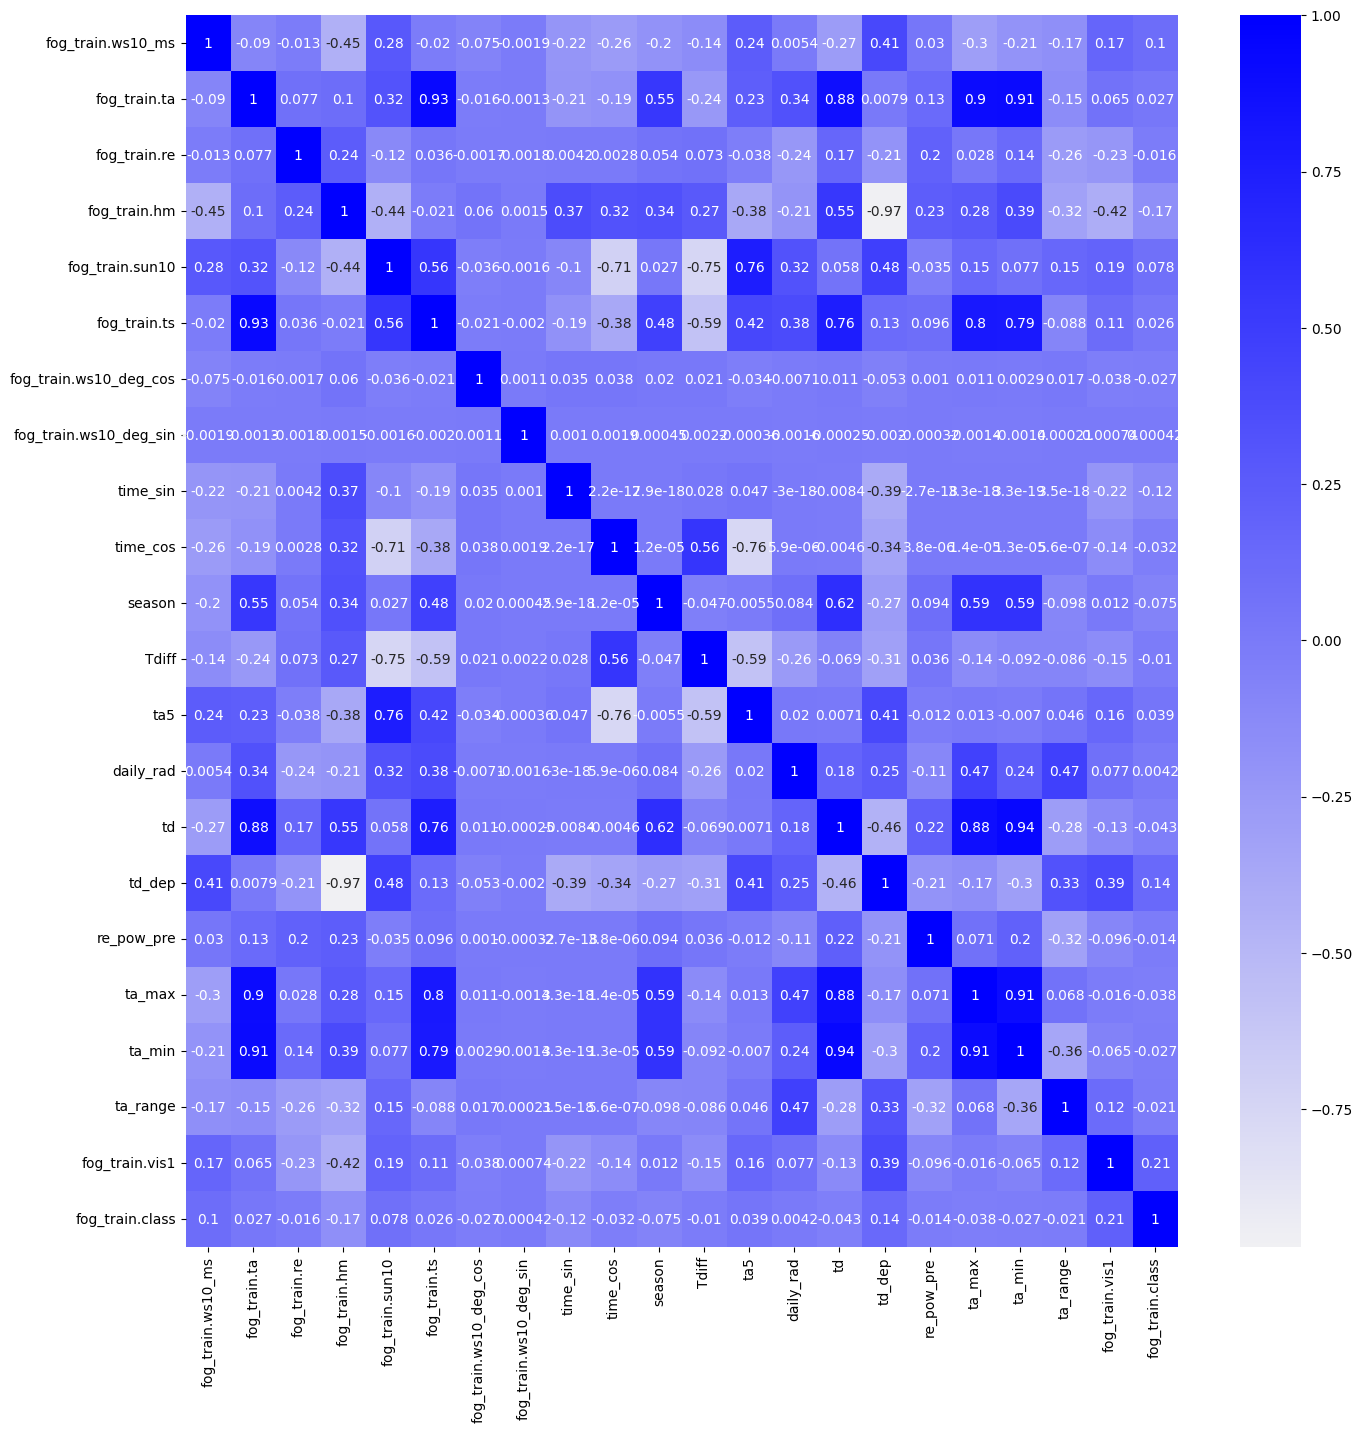

In [ ]:
plt.figure(figsize=(16,16))
cmap = sns.light_palette(color = "b", as_cmap = True)
sns.heatmap(train_B.corr(), annot = True, cmap = cmap)
plt.show()

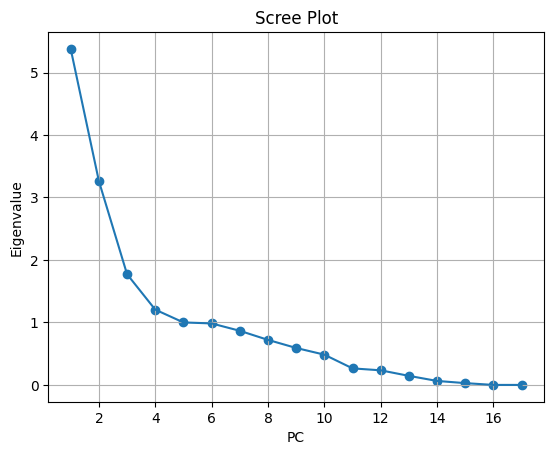

In [ ]:
PCA_df_train_B = train_B.drop(columns = ['fog_train.re', 'fog_train.hm', 'td_dep', 'fog_train.vis1', 'fog_train.class']) # 상대습도는 왜...? -> 여기서 드랍한거 제외하고 pca돌려서 변수 개수 줄임

# 기울기 확 완만해지는데 = pca 개수
fa = FactorAnalyzer(n_factors=PCA_df_train_B.shape[1], rotation=None)
fa.fit(PCA_df_train_B)
ev, v = fa.get_eigenvalues()
plt.scatter(range(1, PCA_df_train_B.shape[1]+1),ev)
plt.plot(range(1,PCA_df_train_B.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('PC')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

In [ ]:
# Eigen value
fa = FactorAnalyzer(n_factors=PCA_df_train_B.shape[1], rotation=None) # rotation:
fa.fit(PCA_df_train_B)

ev, v = fa.get_eigenvalues()
print('eigen value:', ev,'\n', "number of eigen value:", len(ev))

print('적합한 PC 개수:', sum(ev >= 1))

eigen value: [ 5.37746077e+00  3.26272734e+00  1.77142174e+00  1.20514535e+00
  1.00001144e+00  9.84303028e-01  8.66244941e-01  7.20835841e-01
  5.91461587e-01  4.84402725e-01  2.64753015e-01  2.33759613e-01
  1.45017871e-01  6.36500185e-02  2.88047148e-02  2.92324358e-16
 -1.60030586e-15] 
 number of eigen value: 17
적합한 PC 개수: 5


In [ ]:
pca = PCA(n_components = 5)
pca.fit(PCA_df_train_B)
PCA_df_train_B = pca.transform(PCA_df_train_B)
principalDf = pd.DataFrame(data = PCA_df_train_B, columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])

In [ ]:
dump(pca, 'pca_model_B.joblib')

X = pd.concat([train_B[['fog_train.re', 'fog_train.hm', 'td_dep']].reset_index(drop=True), principalDf.reset_index(drop=True)], axis = 1)
y = train_B['fog_train.class'] #일단 class로 했는데, fog_train.vis1로 해도 됨.

In [ ]:
###############################################################
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=2024)

# Further split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=True, random_state=2024)
###############################################################

In [ ]:
import pandas as pd
from sklearn.utils import shuffle
from imblearn.under_sampling import RandomUnderSampler

# X_train, y_train 데이터를 섞습니다.
x_shuffled = shuffle(X_train, random_state=2024)
y_shuffled = shuffle(y_train, random_state=2024)

###############################################################
# 각 클래스의 개수를 확인하여 언더샘플링할 비율을 결정합니다.
counts = y_shuffled.value_counts()
total_of_classes_1_2_3 =  int(3.3 * (counts[1] + counts[2] + counts[3]))
###############################################################


# 언더 샘플링 설정: 클래스 4의 개수를 클래스 1, 2, 3의 총합으로 설정
sampling_strategy = {1: counts[1], 2: counts[2], 3: counts[3], 4: total_of_classes_1_2_3}

# RandomUnderSampler를 사용하여 지정된 비율로 언더 샘플링을 수행합니다.
rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=2024)
X_train_us, y_train_us = rus.fit_resample(x_shuffled, y_shuffled)

# 결과 확인
pd.DataFrame(y_train_us).value_counts()

fog_train.class
4.0                38586
2.0                 5397
3.0                 3653
1.0                 2643
Name: count, dtype: int64

In [ ]:
# 언더샘플링 한거

from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
import numpy as np

# Convert y values to start from 0
y_train_us_transformed = y_train_us - 1     # 1 2 3 4 -> 0 1 2 3
y_val_transformed = y_val - 1     # 1 2 3 4 -> 0 1 2 3
y_test_transformed = y_test - 1     # 1 2 3 4 -> 0 1 2 3

# Define the XGBoost classifier
xgb_model = XGBClassifier(objective='multi:softmax', num_class=4, random_state=2024)

###############################################################
# Define the parameter grid
xgb_params = {
    'learning_rate': [0.015, 0.04, 0.05, 0.06, 0.07],
    'gamma': [0.04, 0.05, 0.06, 0.1, 0.3, 0.5],
    'max_depth': [12, 15, 17, 18, 19],
    'min_child_weight': [1, 2, 3, 4, 5],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.8,0.85, 0.9, 0.95, 1.0],
    'lambda': [0.01, 0.1, 1.0],
    'alpha': [0, 0.1, 0.5, 1.0],
}

# Set up the random search with cross-validation
random_search = RandomizedSearchCV(estimator=xgb_model,
                                   param_distributions=xgb_params,
                                   n_iter=100,  # Number of parameter settings to sample
                                   scoring=csi_scorer, #'f1_score'
                                   cv=5,
                                   verbose=1,
                                   random_state=2024,
                                   n_jobs=-1)
###############################################################

# Fit the model to the training data
random_search.fit(X_train_us, y_train_us_transformed)

# Print the best parameters and the best score
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

# Get the best estimator
best_xgb_model = random_search.best_estimator_

# Evaluate the model on the validation set
val_predictions = best_xgb_model.predict(X_val)
print("Validation F1 Score:", f1_score(y_val_transformed, val_predictions, average='macro'))
print("Validation CSI Score:", multiclass_csi(y_val_transformed, val_predictions))

# Evaluate the model on the test set
test_predictions = best_xgb_model.predict(X_test)
print("Test F1 Score:", f1_score(y_test_transformed, test_predictions, average='macro'))
print("Test CSI Score:", multiclass_csi(y_test_transformed, test_predictions))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters: {'subsample': 0.9, 'min_child_weight': 1, 'max_depth': 17, 'learning_rate': 0.05, 'lambda': 0.01, 'gamma': 0.04, 'colsample_bytree': 1.0, 'alpha': 0}
Best Score: 0.46689507986542367
Validation F1 Score: 0.4879202866351393
Validation CSI Score: 0.21664925113200975
Test F1 Score: 0.5038932147760027
Test CSI Score: 0.23516949152542374


In [ ]:
# 단순히 accuracy 말고도 precision, recall 등의 값들 추출 가능
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# 평가 지표 출력
print('정확도 accuracy: %.3f' % accuracy_score(y_test_transformed, test_predictions))
print('정밀도 precision: %.3f' % precision_score(y_true=y_test_transformed, y_pred=test_predictions, average='macro'))
print('재현율 recall: %.3f' % recall_score(y_true=y_test_transformed, y_pred=test_predictions, average='macro'))
print('F1-score: %.3f' % f1_score(y_true=y_test_transformed, y_pred=test_predictions, average='macro'))
print('AUC: %.3f' % roc_auc_score(y_test_transformed, best_xgb_model.predict_proba(X_test), multi_class='ovr'))
print("Test CSI Score:", multiclass_csi(y_true=y_test_transformed, y_pred=test_predictions))

정확도 accuracy: 0.960
정밀도 precision: 0.451
재현율 recall: 0.628
F1-score: 0.504
AUC: 0.975
Test CSI Score: 0.23516949152542374


In [ ]:
dump(best_xgb_model, 'xgb_b.pt')

['xgb_b.pt']

# xgb classifier (C)

In [ ]:
train_C = pd.read_csv('/content/drive/MyDrive/기상청빅데이터/과제 2/모델 중간 데이터/train_C.csv')

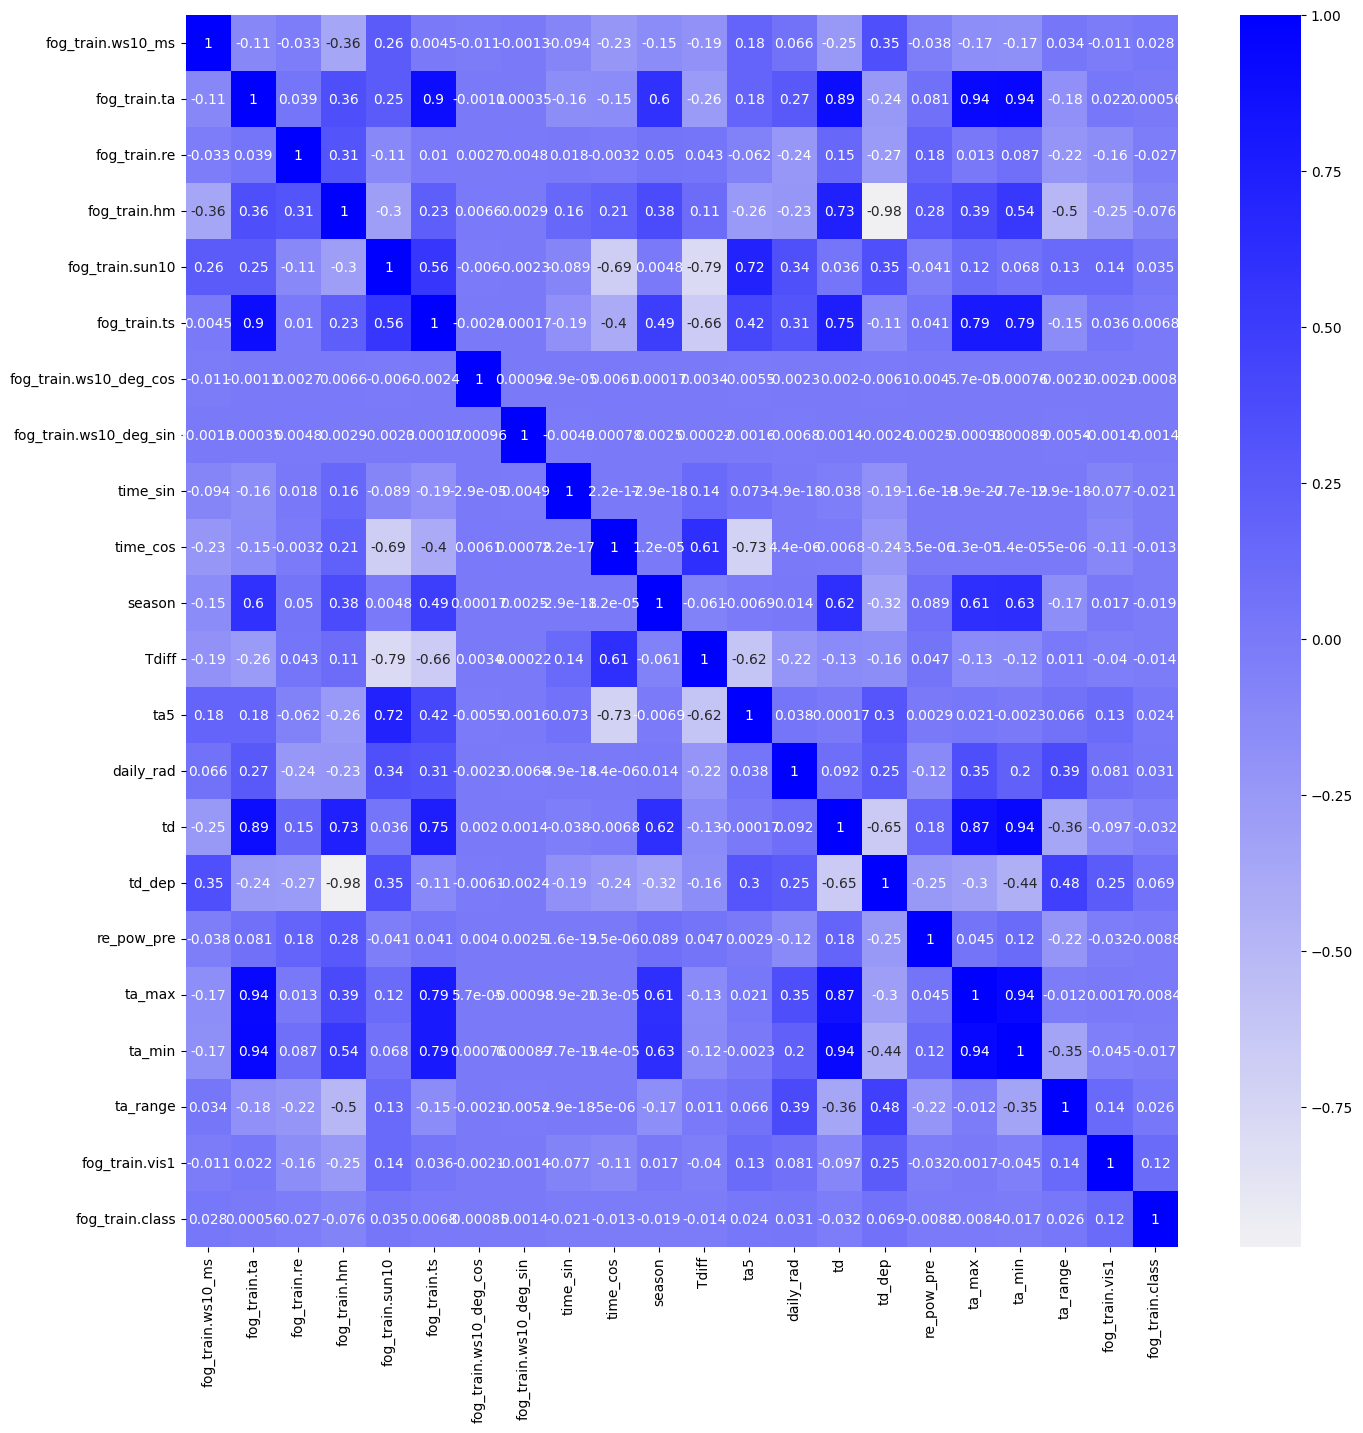

In [ ]:
plt.figure(figsize=(16,16))
cmap = sns.light_palette(color = "b", as_cmap = True)
sns.heatmap(train_C.corr(), annot = True, cmap = cmap)
plt.show()

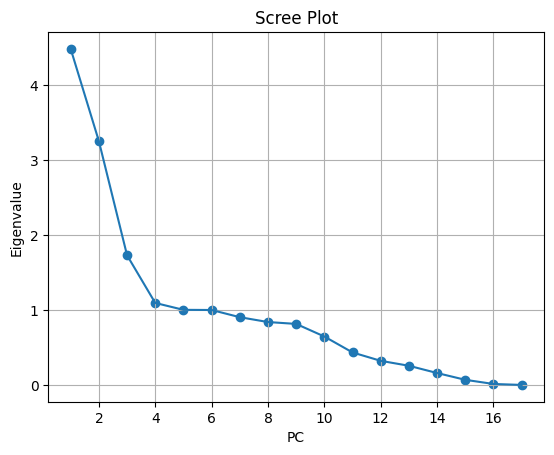

In [ ]:
PCA_df_train_C = train_C.drop(columns = ['fog_train.ta', 'fog_train.hm', 'td_dep', 'fog_train.vis1', 'fog_train.class']) # 상대습도는 왜...? -> 여기서 드랍한거 제외하고 pca돌려서 변수 개수 줄임

# 기울기 확 완만해지는데 = pca 개수
fa = FactorAnalyzer(n_factors=PCA_df_train_C.shape[1], rotation=None)
fa.fit(PCA_df_train_C)
ev, v = fa.get_eigenvalues()
plt.scatter(range(1, PCA_df_train_C.shape[1]+1),ev)
plt.plot(range(1,PCA_df_train_C.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('PC')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

In [ ]:
# Eigen value
fa = FactorAnalyzer(n_factors=PCA_df_train_C.shape[1], rotation=None) # rotation:
fa.fit(PCA_df_train_C)

ev, v = fa.get_eigenvalues()
print('eigen value:', ev,'\n', "number of eigen value:", len(ev))

print('적합한 PC 개수:', sum(ev >= 1))

eigen value: [ 4.47963214e+00  3.24998798e+00  1.72815477e+00  1.09290214e+00
  1.00113858e+00  9.98884915e-01  9.02933639e-01  8.38386365e-01
  8.13346999e-01  6.45453153e-01  4.33025764e-01  3.21114452e-01
  2.55472304e-01  1.58666628e-01  6.82154802e-02  1.26846886e-02
 -4.44089846e-16] 
 number of eigen value: 17
적합한 PC 개수: 5


In [ ]:
pca = PCA(n_components = 5)
pca.fit(PCA_df_train_C)
PCA_df_train_C = pca.transform(PCA_df_train_C)
principalDf = pd.DataFrame(data = PCA_df_train_C, columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])

In [ ]:
dump(pca, 'pca_model_C.joblib')

X = pd.concat([train_C[['fog_train.ta', 'fog_train.hm', 'td_dep']].reset_index(drop=True), principalDf.reset_index(drop=True)], axis = 1)
y = train_C['fog_train.class'] #일단 class로 했는데, fog_train.vis1로 해도 됨.

In [ ]:
###############################################################
# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=2024)

# Further split the training data into training and validation sets (80% of the original training data)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=True, random_state=2024)
###############################################################

In [ ]:
# 언더샘플링 방식2

import pandas as pd
from sklearn.utils import shuffle
from imblearn.under_sampling import RandomUnderSampler

# X_train, y_train 데이터를 섞습니다.
x_shuffled = shuffle(X_train, random_state=2024)
y_shuffled = shuffle(y_train, random_state=2024)

###############################################################
# 각 클래스의 개수를 확인하여 언더샘플링할 비율을 결정합니다.
counts = y_shuffled.value_counts()
total_of_classes_1_2_3 = 6 * (counts[1] + counts[2] + counts[3])
###############################################################

# 언더 샘플링 설정: 클래스 4의 개수를 클래스 1, 2, 3의 총합으로 설정
sampling_strategy = {1: counts[1], 2: counts[2], 3: counts[3], 4: total_of_classes_1_2_3}

# RandomUnderSampler를 사용하여 지정된 비율로 언더 샘플링을 수행합니다.
rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=2024)
X_train_us, y_train_us = rus.fit_resample(x_shuffled, y_shuffled)

# 결과 확인
pd.DataFrame(y_train_us).value_counts()

fog_train.class
4.0                8574
2.0                 556
3.0                 520
1.0                 353
Name: count, dtype: int64

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
import numpy as np

# Convert y values to start from 0
y_train_us_transformed = y_train_us - 1     # 1 2 3 4 -> 0 1 2 3
y_val_transformed = y_val - 1     # 1 2 3 4 -> 0 1 2 3
y_test_transformed = y_test - 1     # 1 2 3 4 -> 0 1 2 3

# Define the XGBoost classifier
xgb_model = XGBClassifier(objective='multi:softmax', num_class=4, random_state=2024)

###############################################################
# Define the parameter grid
xgb_params = {
    'learning_rate': [0.01, 0.015, 0.025, 0.05, 0.1],
    'gamma': [0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
    'max_depth': [3, 5, 7, 9, 12, 15, 17, 25],
    'min_child_weight': [1, 3, 5, 7],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'lambda': [0.01, 0.1, 1.0],
    'alpha': [0, 0.1, 0.5, 1.0],
}

# Set up the random search with cross-validation
random_search = RandomizedSearchCV(estimator=xgb_model,
                                   param_distributions=xgb_params,
                                   n_iter=100,  # Number of parameter settings to sample
                                   scoring=csi_scorer, #'f1_score'
                                   cv=5,
                                   verbose=1,
                                   random_state=2024,
                                   n_jobs=-1)
###############################################################

# Fit the model to the training data
random_search.fit(X_train_us, y_train_us_transformed)

# Print the best parameters and the best score
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

# Get the best estimator
best_xgb_model = random_search.best_estimator_

# Evaluate the model on the validation set
val_predictions = best_xgb_model.predict(X_val)
print("Validation F1 Score:", f1_score(y_val_transformed, val_predictions, average='macro'))
print("Validation CSI Score:", multiclass_csi(y_val_transformed, val_predictions))

# Evaluate the model on the test set
test_predictions = best_xgb_model.predict(X_test)
print("Test F1 Score:", f1_score(y_test_transformed, test_predictions, average='macro'))
print("Test CSI Score:", multiclass_csi(y_test_transformed, test_predictions))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters: {'subsample': 0.9, 'min_child_weight': 1, 'max_depth': 17, 'learning_rate': 0.01, 'lambda': 0.1, 'gamma': 0.05, 'colsample_bytree': 0.9, 'alpha': 0}
Best Score: 0.3706605937860073
Validation F1 Score: 0.4608383766698585
Validation CSI Score: 0.14558472553699284
Test F1 Score: 0.45606552234198083
Test CSI Score: 0.15074309978768577


In [ ]:
# 단순히 accuracy 말고도 precision, recall 등의 값들 추출 가능

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# 평가 지표 출력
print('정확도 accuracy: %.3f' % accuracy_score(y_test_transformed, test_predictions))
print('정밀도 precision: %.3f' % precision_score(y_true=y_test_transformed, y_pred=test_predictions, average='macro'))
print('재현율 recall: %.3f' % recall_score(y_true=y_test_transformed, y_pred=test_predictions, average='macro'))
print('F1-score: %.3f' % f1_score(y_true=y_test_transformed, y_pred=test_predictions, average='macro'))
print('AUC: %.3f' % roc_auc_score(y_test_transformed, best_xgb_model.predict_proba(X_test), multi_class='ovr'))
print("Test CSI Score:", multiclass_csi(y_true=y_test_transformed, y_pred=test_predictions))

정확도 accuracy: 0.987
정밀도 precision: 0.404
재현율 recall: 0.571
F1-score: 0.456
AUC: 0.959
Test CSI Score: 0.15074309978768577


In [ ]:
dump(best_xgb_model, 'xgb_c.pt')

['xgb_c.pt']

# xgb classifier (D)

In [ ]:
train_D = pd.read_csv('/content/drive/MyDrive/기상청빅데이터/과제 2/모델 중간 데이터/train_D.csv')

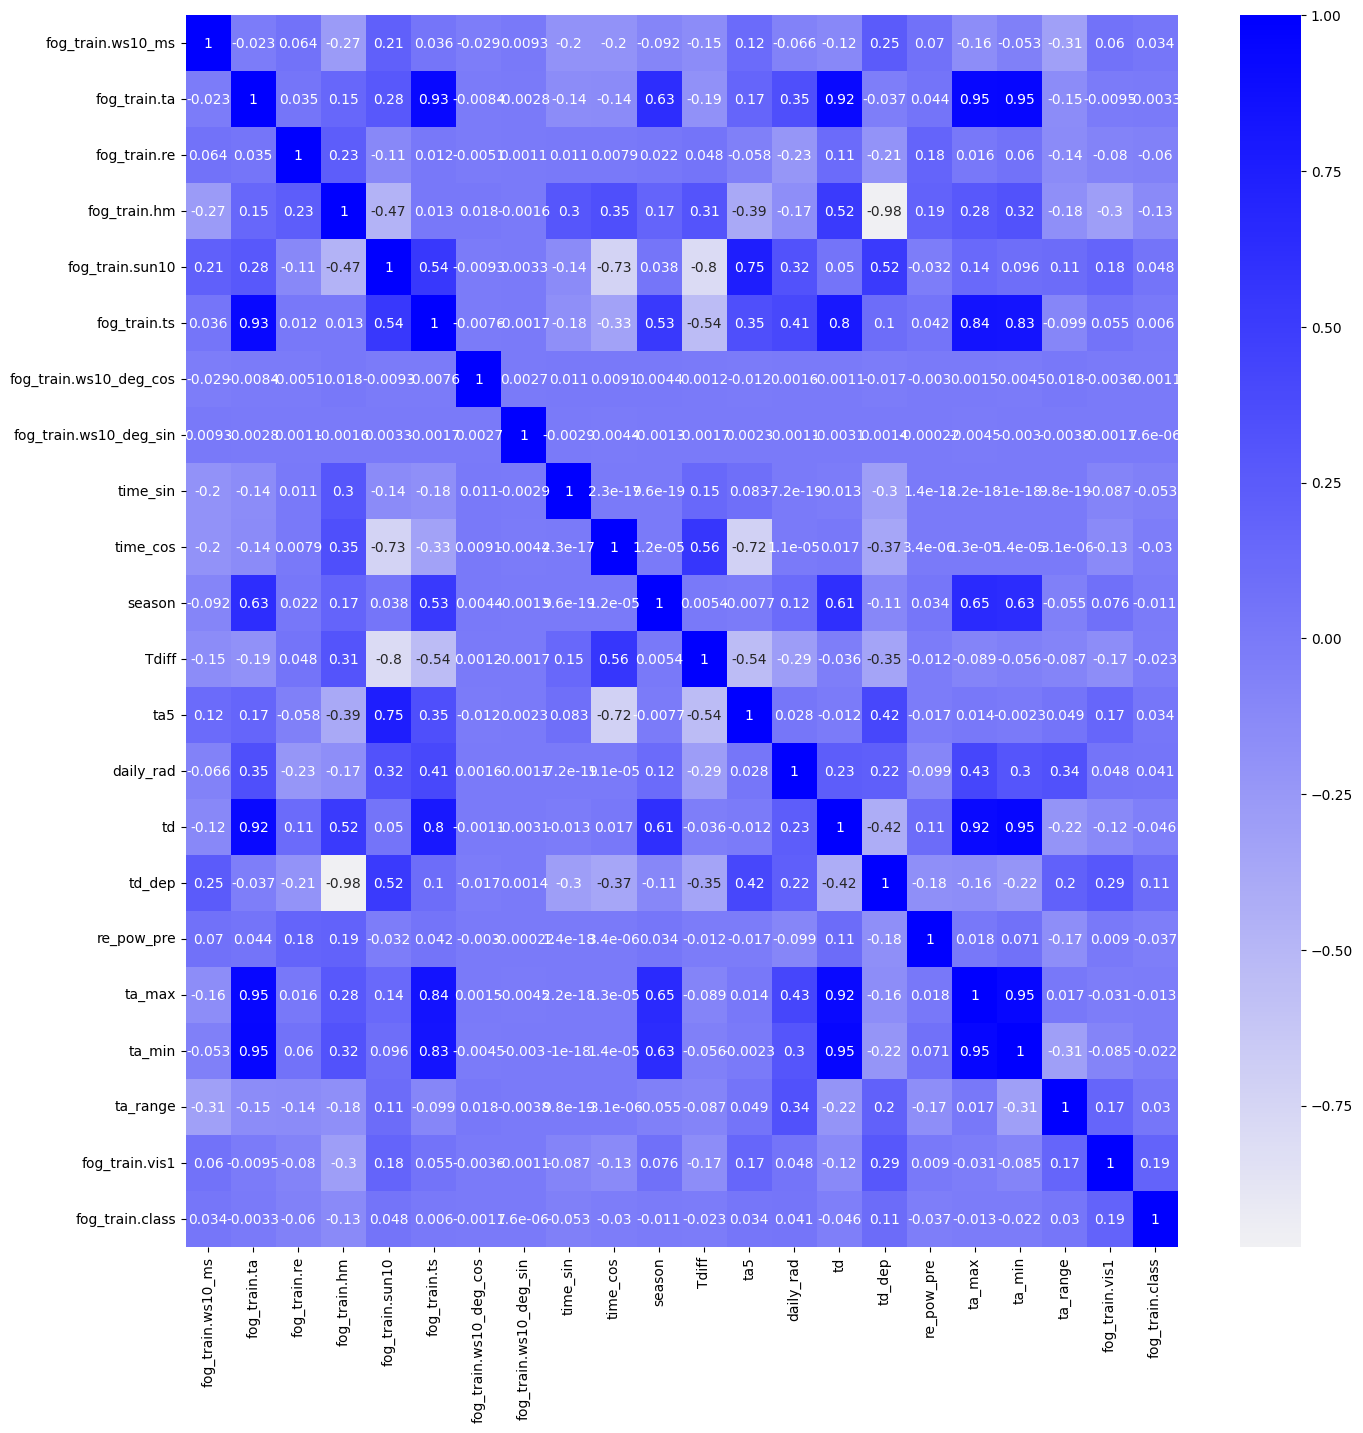

In [ ]:
plt.figure(figsize=(16,16))
cmap = sns.light_palette(color = "b", as_cmap = True)
sns.heatmap(train_D.corr(), annot = True, cmap = cmap)
plt.show()

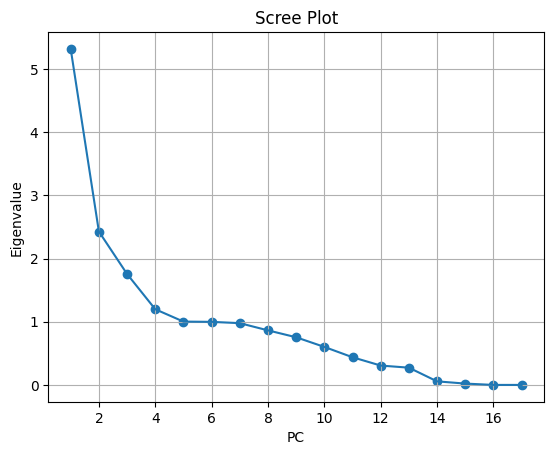

In [ ]:
PCA_df_train_D = train_D.drop(columns = ['fog_train.sun10', 'fog_train.hm', 'td_dep', 'fog_train.vis1', 'fog_train.class']) # 상대습도는 왜...? -> 여기서 드랍한거 제외하고 pca돌려서 변수 개수 줄임

# 기울기 확 완만해지는데 = pca 개수
fa = FactorAnalyzer(n_factors=PCA_df_train_D.shape[1], rotation=None)
fa.fit(PCA_df_train_D)
ev, v = fa.get_eigenvalues()
plt.scatter(range(1, PCA_df_train_D.shape[1]+1),ev)
plt.plot(range(1,PCA_df_train_D.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('PC')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

In [ ]:
# Eigen value
fa = FactorAnalyzer(n_factors=PCA_df_train_D.shape[1], rotation=None) # rotation:
fa.fit(PCA_df_train_D)

ev, v = fa.get_eigenvalues()
print('eigen value:', ev,'\n', "number of eigen value:", len(ev))

print('적합한 PC 개수:', sum(ev >= 1))

eigen value: [ 5.32059787e+00  2.42889017e+00  1.75668045e+00  1.19847154e+00
  1.00292681e+00  9.98612606e-01  9.78015711e-01  8.63882504e-01
  7.54533052e-01  6.01836909e-01  4.38248104e-01  3.06646137e-01
  2.73102285e-01  5.63410321e-02  2.12148264e-02  1.26267760e-15
 -9.71273664e-16] 
 number of eigen value: 17
적합한 PC 개수: 5


In [ ]:
pca = PCA(n_components = 5)
pca.fit(PCA_df_train_D)
PCA_df_train_D = pca.transform(PCA_df_train_D)
principalDf = pd.DataFrame(data = PCA_df_train_D, columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])

In [ ]:
dump(pca, 'pca_model_D.joblib')

X = pd.concat([train_D[['fog_train.sun10', 'fog_train.hm', 'td_dep']].reset_index(drop=True), principalDf.reset_index(drop=True)], axis = 1)
y = train_D['fog_train.class'] #일단 class로 했는데, fog_train.vis1로 해도 됨.

In [ ]:
###############################################################
# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=2024)

# Further split the training data into training and validation sets (80% of the original training data)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=True, random_state=2024)
###############################################################

In [ ]:
# 언더샘플링 방식2

import pandas as pd
from sklearn.utils import shuffle
from imblearn.under_sampling import RandomUnderSampler

# X_train, y_train 데이터를 섞습니다.
x_shuffled = shuffle(X_train, random_state=2024)
y_shuffled = shuffle(y_train, random_state=2024)

###############################################################
# 각 클래스의 개수를 확인하여 언더샘플링할 비율을 결정합니다.
counts = y_shuffled.value_counts()
total_of_classes_1_2_3 = 4 * (counts[1] + counts[2] + counts[3])
###############################################################

# 언더 샘플링 설정: 클래스 4의 개수를 클래스 1, 2, 3의 총합으로 설정
sampling_strategy = {1: counts[1], 2: counts[2], 3: counts[3], 4: total_of_classes_1_2_3}

# RandomUnderSampler를 사용하여 지정된 비율로 언더 샘플링을 수행합니다.
rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=2024)
X_train_us, y_train_us = rus.fit_resample(x_shuffled, y_shuffled)

# 결과 확인
pd.DataFrame(y_train_us).value_counts()

fog_train.class
4.0                23804
3.0                 2052
1.0                 1999
2.0                 1900
Name: count, dtype: int64

In [ ]:
# 언더샘플링 한거

from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
import numpy as np

# Convert y values to start from 0
y_train_us_transformed = y_train_us - 1     # 1 2 3 4 -> 0 1 2 3
y_val_transformed = y_val - 1     # 1 2 3 4 -> 0 1 2 3
y_test_transformed = y_test - 1     # 1 2 3 4 -> 0 1 2 3

# Define the XGBoost classifier
xgb_model = XGBClassifier(objective='multi:softmax', num_class=4, random_state=2024)

###############################################################
# Define the parameter grid
xgb_params = {
    'learning_rate': [0.01, 0.015, 0.025, 0.05, 0.1],
    'gamma': [0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
    'max_depth': [3, 5, 7, 9, 12, 15, 17, 25],
    'min_child_weight': [1, 3, 5, 7],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'lambda': [0.01, 0.1, 1.0],
    'alpha': [0, 0.1, 0.5, 1.0],
}

# Set up the random search with cross-validation
random_search = RandomizedSearchCV(estimator=xgb_model,
                                   param_distributions=xgb_params,
                                   n_iter=100,  # Number of parameter settings to sample
                                   scoring=csi_scorer, #'f1_score'
                                   cv=5,
                                   verbose=1,
                                   random_state=2024,
                                   n_jobs=-1)
###############################################################

# Fit the model to the training data
random_search.fit(X_train_us, y_train_us_transformed)

# Print the best parameters and the best score
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

# Get the best estimator
best_xgb_model = random_search.best_estimator_

# Evaluate the model on the validation set
val_predictions = best_xgb_model.predict(X_val)
print("Validation F1 Score:", f1_score(y_val_transformed, val_predictions, average='macro'))
print("Validation CSI Score:", multiclass_csi(y_val_transformed, val_predictions))

# Evaluate the model on the test set
test_predictions = best_xgb_model.predict(X_test)
print("Test F1 Score:", f1_score(y_test_transformed, test_predictions, average='macro'))
print("Test CSI Score:", multiclass_csi(y_test_transformed, test_predictions))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters: {'subsample': 0.9, 'min_child_weight': 1, 'max_depth': 17, 'learning_rate': 0.01, 'lambda': 0.1, 'gamma': 0.05, 'colsample_bytree': 0.9, 'alpha': 0}
Best Score: 0.4283171275868757
Validation F1 Score: 0.5028702362084886
Validation CSI Score: 0.2195945945945946
Test F1 Score: 0.48890601267578215
Test CSI Score: 0.20600858369098712


In [ ]:
# 단순히 accuracy 말고도 precision, recall 등의 값들 추출 가능

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# 평가 지표 출력
print('정확도 accuracy: %.3f' % accuracy_score(y_test_transformed, test_predictions))
print('정밀도 precision: %.3f' % precision_score(y_true=y_test_transformed, y_pred=test_predictions, average='macro'))
print('재현율 recall: %.3f' % recall_score(y_true=y_test_transformed, y_pred=test_predictions, average='macro'))
print('F1-score: %.3f' % f1_score(y_true=y_test_transformed, y_pred=test_predictions, average='macro'))
print('AUC: %.3f' % roc_auc_score(y_test_transformed, best_xgb_model.predict_proba(X_test), multi_class='ovr'))
print("Test CSI Score:", multiclass_csi(y_true=y_test_transformed, y_pred=test_predictions))

정확도 accuracy: 0.973
정밀도 precision: 0.439
재현율 recall: 0.583
F1-score: 0.489
AUC: 0.946
Test CSI Score: 0.20600858369098712


In [ ]:
dump(best_xgb_model, 'xgb_d.pt')

['xgb_d.pt']

# xgb classifier (E)

In [ ]:
train_E = pd.read_csv('/content/drive/MyDrive/기상청빅데이터/과제 2/모델 중간 데이터/train_E.csv')

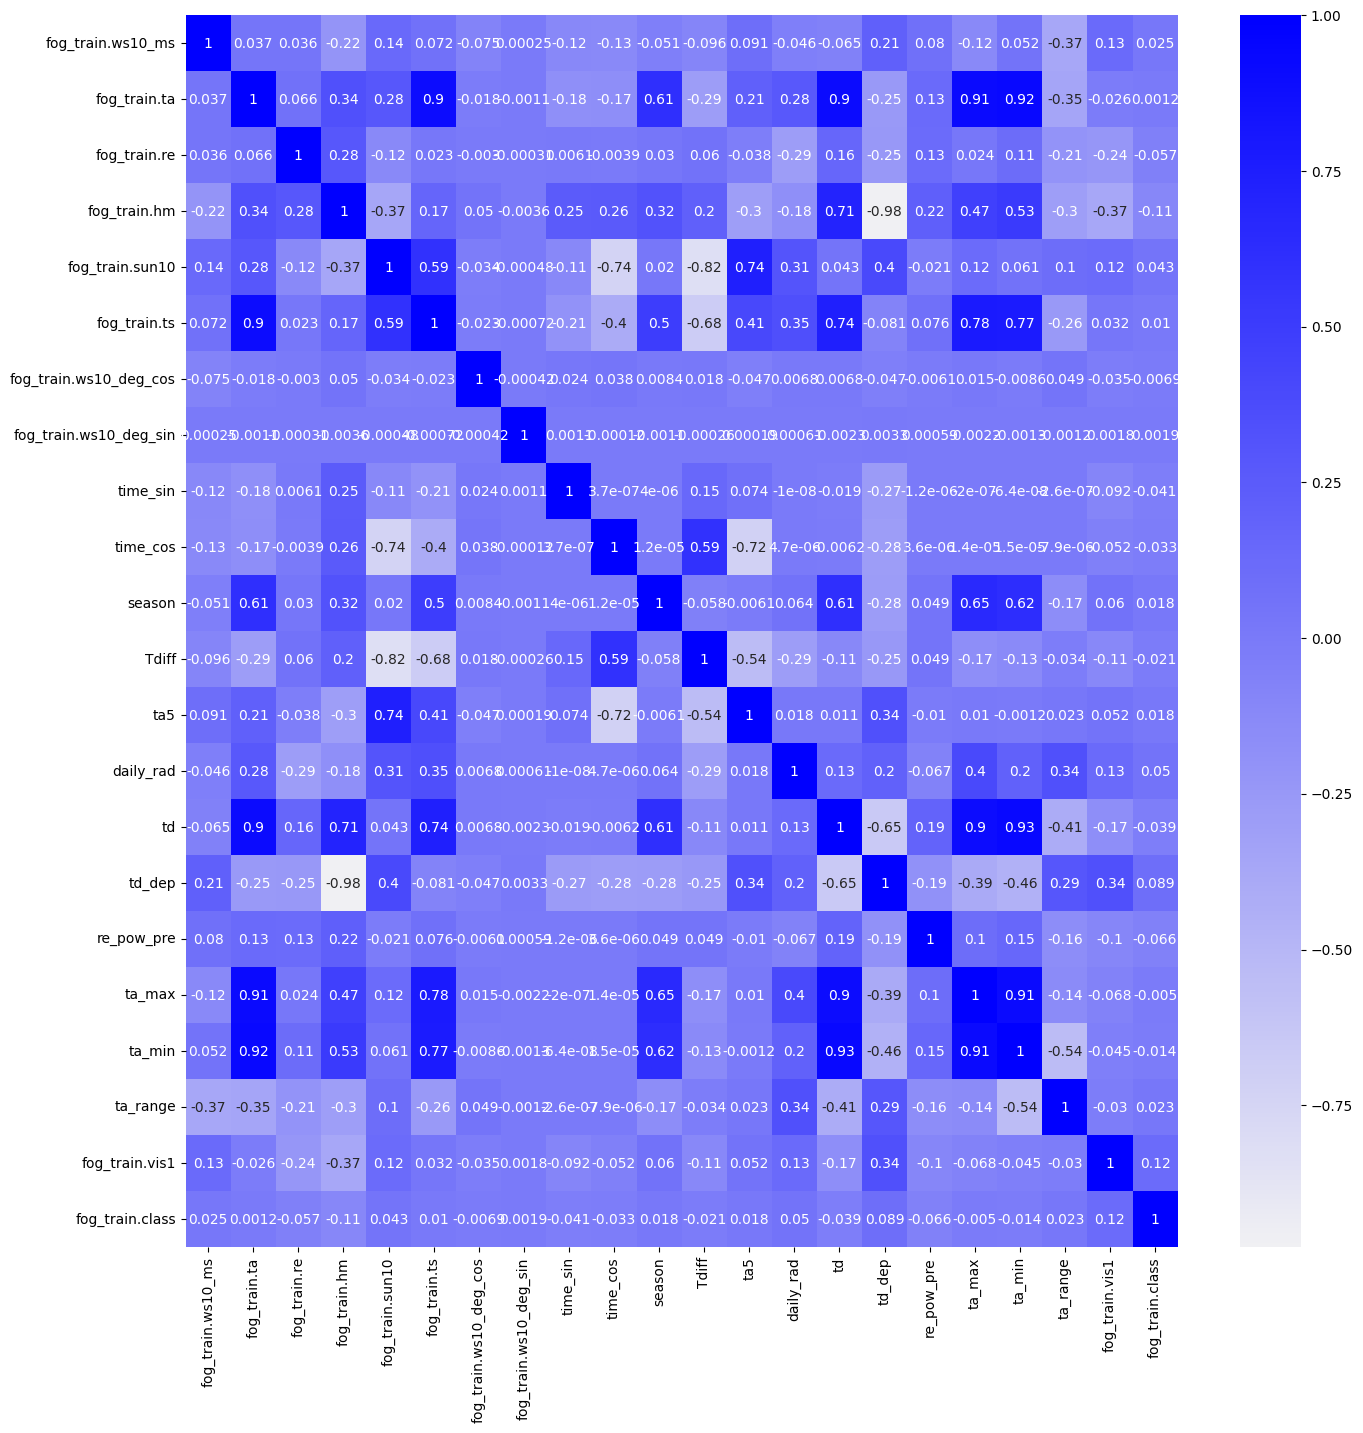

In [ ]:
plt.figure(figsize=(16,16))
cmap = sns.light_palette(color = "b", as_cmap = True)
sns.heatmap(train_E.corr(), annot = True, cmap = cmap)
plt.show()

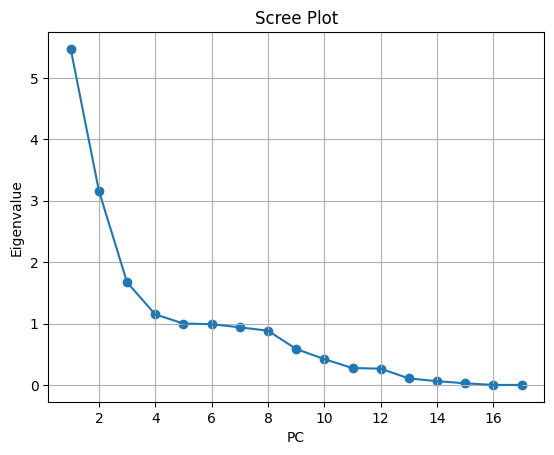

In [ ]:
PCA_df_train_E = train_E.drop(columns = ['fog_train.re', 'fog_train.hm', 'td_dep', 'fog_train.vis1', 'fog_train.class']) # 상대습도는 왜...? -> 여기서 드랍한거 제외하고 pca돌려서 변수 개수 줄임

# 기울기 확 완만해지는데 = pca 개수
fa = FactorAnalyzer(n_factors=PCA_df_train_E.shape[1], rotation=None)
fa.fit(PCA_df_train_E)
ev, v = fa.get_eigenvalues()
plt.scatter(range(1, PCA_df_train_E.shape[1]+1),ev)
plt.plot(range(1,PCA_df_train_E.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('PC')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

In [ ]:
# Eigen value
fa = FactorAnalyzer(n_factors=PCA_df_train_E.shape[1], rotation=None) # rotation:
fa.fit(PCA_df_train_E)

ev, v = fa.get_eigenvalues()
print('eigen value:', ev,'\n', "number of eigen value:", len(ev))

print('적합한 PC 개수:', sum(ev >= 1))

eigen value: [ 5.47166523e+00  3.16192848e+00  1.67073983e+00  1.14798757e+00
  1.00005027e+00  9.88893472e-01  9.37787691e-01  8.82993408e-01
  5.85427971e-01  4.19855315e-01  2.74756581e-01  2.64958225e-01
  1.05394936e-01  6.09413867e-02  2.66196361e-02  2.77580759e-15
 -3.05561365e-16] 
 number of eigen value: 17
적합한 PC 개수: 5


In [ ]:
pca = PCA(n_components = 5)
pca.fit(PCA_df_train_E)
PCA_df_train_E = pca.transform(PCA_df_train_E)
principalDf = pd.DataFrame(data = PCA_df_train_E, columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])

In [ ]:
dump(pca, 'pca_model_E.joblib')

X = pd.concat([train_E[['fog_train.re', 'fog_train.hm', 'td_dep']].reset_index(drop=True), principalDf.reset_index(drop=True)], axis = 1)
y = train_E['fog_train.class'] #일단 class로 했는데, fog_train.vis1로 해도 됨.

In [ ]:
###############################################################
# Split the data into training and testing sets (90% train, 10% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=2024)

# Further split the training data into training and validation sets (90% of the original training data)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=True, random_state=2024)
###############################################################

In [ ]:
# 언더샘플링 방식2

import pandas as pd
from sklearn.utils import shuffle
from imblearn.under_sampling import RandomUnderSampler

# X_train, y_train 데이터를 섞습니다.
x_shuffled = shuffle(X_train, random_state=2024)
y_shuffled = shuffle(y_train, random_state=2024)

###############################################################
# 각 클래스의 개수를 확인하여 언더샘플링할 비율을 결정합니다.
counts = y_shuffled.value_counts()
total_of_classes_1_2_3 = 6 * (counts[1] + counts[2] + counts[3])
###############################################################

# 언더 샘플링 설정: 클래스 4의 개수를 클래스 1, 2, 3의 총합으로 설정
sampling_strategy = {1: counts[1], 2: counts[2], 3: counts[3], 4: total_of_classes_1_2_3}

# RandomUnderSampler를 사용하여 지정된 비율로 언더 샘플링을 수행합니다.
rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=2024)
X_train_us, y_train_us = rus.fit_resample(x_shuffled, y_shuffled)

# 결과 확인
pd.DataFrame(y_train_us).value_counts()

fog_train.class
4.0                13878
3.0                  907
1.0                  709
2.0                  697
Name: count, dtype: int64

In [ ]:
# 언더샘플링 한거

from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
import numpy as np

# Convert y values to start from 0
y_train_us_transformed = y_train_us - 1     # 1 2 3 4 -> 0 1 2 3
y_val_transformed = y_val - 1     # 1 2 3 4 -> 0 1 2 3
y_test_transformed = y_test - 1     # 1 2 3 4 -> 0 1 2 3

# Define the XGBoost classifier
xgb_model = XGBClassifier(objective='multi:softmax', num_class=4, random_state=2024)

###############################################################
# Define the parameter grid
xgb_params = {
    'learning_rate': [0.01, 0.015, 0.025, 0.05, 0.1],
    'gamma': [0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
    'max_depth': [3, 5, 7, 9, 12, 15, 17, 25],
    'min_child_weight': [1, 3, 5, 7],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'lambda': [0.01, 0.1, 1.0],
    'alpha': [0, 0.1, 0.5, 1.0],
}

# Set up the random search with cross-validation
random_search = RandomizedSearchCV(estimator=xgb_model,
                                   param_distributions=xgb_params,
                                   n_iter=100,  # Number of parameter settings to sample
                                   scoring=csi_scorer, #'f1_score'
                                   cv=5,
                                   verbose=1,
                                   random_state=2024,
                                   n_jobs=-1)
###############################################################

# Fit the model to the training data
random_search.fit(X_train_us, y_train_us_transformed)

# Print the best parameters and the best score
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

# Get the best estimator
best_xgb_model = random_search.best_estimator_

# Evaluate the model on the validation set
val_predictions = best_xgb_model.predict(X_val)
print("Validation F1 Score:", f1_score(y_val_transformed, val_predictions, average='macro'))
print("Validation CSI Score:", multiclass_csi(y_val_transformed, val_predictions))

# Evaluate the model on the test set
test_predictions = best_xgb_model.predict(X_test)
print("Test F1 Score:", f1_score(y_test_transformed, test_predictions, average='macro'))
print("Test CSI Score:", multiclass_csi(y_test_transformed, test_predictions))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters: {'subsample': 0.9, 'min_child_weight': 1, 'max_depth': 17, 'learning_rate': 0.01, 'lambda': 0.1, 'gamma': 0.05, 'colsample_bytree': 0.9, 'alpha': 0}
Best Score: 0.46725380448980847
Validation F1 Score: 0.4538673976860418
Validation CSI Score: 0.1396534148827727
Test F1 Score: 0.4510614600339411
Test CSI Score: 0.1323251417769376


In [ ]:
# 단순히 accuracy 말고도 precision, recall 등의 값들 추출 가능

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# 평가 지표 출력
print('정확도 accuracy: %.3f' % accuracy_score(y_test_transformed, test_predictions))
print('정밀도 precision: %.3f' % precision_score(y_true=y_test_transformed, y_pred=test_predictions, average='macro'))
print('재현율 recall: %.3f' % recall_score(y_true=y_test_transformed, y_pred=test_predictions, average='macro'))
print('F1-score: %.3f' % f1_score(y_true=y_test_transformed, y_pred=test_predictions, average='macro'))
print('AUC: %.3f' % roc_auc_score(y_test_transformed, best_xgb_model.predict_proba(X_test), multi_class='ovr'))
print("Test CSI Score:", multiclass_csi(y_true=y_test_transformed, y_pred=test_predictions))

정확도 accuracy: 0.981
정밀도 precision: 0.389
재현율 recall: 0.653
F1-score: 0.451
AUC: 0.977
Test CSI Score: 0.1323251417769376


In [ ]:
dump(best_xgb_model, 'xgb_e.pt')

['xgb_e.pt']